In [636]:
import os
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

from scipy import stats
import scipy.cluster.hierarchy as sch

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [637]:
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats
from scipy import signal
from ast import literal_eval
import torch

from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

pd.set_option('display.max_columns', None)

DATAPATH = "~/datasets/stressrecov"

EXTENSION = "/oura"

sleep_df = pd.read_parquet("~/stressrecovery/data/processed/oura/sleep_concat.parquet")

sleep_df['date']=sleep_df['date'].astype(str) 

daily_merged = pd.read_parquet("~/stressrecovery/data/processed/survey/daily_merged.parquet")
daily_merged['date']=daily_merged['date'].astype(str) 

daily_merged["covid_shift_any"] = daily_merged.apply (lambda row: (row.daily_covid_shifts___1 or row.daily_covid_shifts___2 or row.daily_covid_shifts___3 ), axis=1)

In [638]:
df = pd.merge(sleep_df, daily_merged,  how='left', on=["participant_id","date"])
df['date'] = df["date"].astype(str)
df['date'] = pd.to_datetime(df["date"])

#df.sort_values(['participant_id', 'date'], ascending=True)


In [639]:
columns = ['date', 'participant_id', 'rmssd', 'hr_average', 'awake', 'deep', 'total']
df = df[columns]

In [640]:
# find participant IDs with > 150 data points 
keep = df.groupby("participant_id").filter(lambda x: len(x) > 150)
participants= keep.participant_id.unique()

In [641]:
# number of participants kept 
len(keep.participant_id.unique())

192

In [642]:
# filter df
new_df = df[df.participant_id.isin(participants)]

In [643]:
# create a new data frame with first 50 records for each participant (used for clustering)
df_clustering = new_df.groupby('participant_id').head(50).reset_index(drop=True)

In [644]:
# create a new data frame with last 100 records for each participant (used for FIT)
df_FIT = new_df.groupby('participant_id').tail(100).reset_index(drop=True)

In [645]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

def construct_dataset(df):
    x = []
    
    participants = df.participant_id.unique()
    
    #keep data we want, drop the rest
    df_subset = df

    for participant in participants:
        df = df_subset[df_subset["participant_id"] == participant]
        
        #Create Empty NaN rows for missing dates
        df = df.set_index('date')
        df = df.resample('D').mean()
        
        #Forward Fill missing values. If time stamp is missing, fill with column mean
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        
        #if any still missing fill with population mean
        df = df.fillna(df_subset.mean())
        
        if len(df) >= 50:
            window = df.iloc[0:50,:]
            data = window.values
            standardized_data = StandardScaler().fit_transform(data)
            standardized_df = pd.DataFrame(standardized_data)
            arrays = [np.array(standardized_df[column]) for column in standardized_df.columns]
            x.append(np.stack(arrays, axis=0))
    return np.array(x)

In [646]:
arr_clustering = construct_dataset(df_clustering)

In [647]:
arr_clustering.shape #samples, #features, #time points 

(181, 5, 50)

In [648]:
# reshape to #samples #time points # features
arr_clustering=arr_clustering.reshape((arr_clustering.shape[0],arr_clustering.shape[2], arr_clustering.shape[1]))

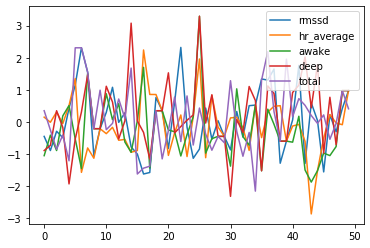

In [650]:
plt.plot(arr_clustering[1])
plt.legend([ 'rmssd', 'hr_average', 'awake', 'deep', 'total'])

In [651]:
from tensorflow.keras import layers, losses

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    return autoencoder

In [652]:
autoencoder = get_autoencoder(arr_clustering)
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 50, 5)]           0         
_________________________________________________________________
time_distributed_126 (TimeDi (None, 50, 200)           1200      
_________________________________________________________________
time_distributed_127 (TimeDi (None, 50, 50)            10050     
_________________________________________________________________
time_distributed_128 (TimeDi (None, 50, 10)            510       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 50, 50)            550       
_________________________________________________________________
time_distributed_130 (TimeDi (None, 50, 200)           10200     
_________________________________________________________________
time_distributed_131 (TimeDi (None, 50, 5)             100

In [691]:
# performance measure to monitor in order to end training: val_loss
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(arr_clustering)
autoencoder.fit(arr_clustering[:50],arr_clustering[:50], epochs=200, verbose=2, validation_data=(arr_clustering[51:70],arr_clustering[51:70]))#, callbacks=[es])




Epoch 1/200
2/2 - 1s - loss: 1.0022 - val_loss: 0.8329
Epoch 2/200
2/2 - 0s - loss: 0.7874 - val_loss: 0.6618
Epoch 3/200
2/2 - 0s - loss: 0.6216 - val_loss: 0.5213
Epoch 4/200
2/2 - 0s - loss: 0.4873 - val_loss: 0.4053
Epoch 5/200
2/2 - 0s - loss: 0.3798 - val_loss: 0.3175
Epoch 6/200
2/2 - 0s - loss: 0.3020 - val_loss: 0.2608
Epoch 7/200
2/2 - 0s - loss: 0.2520 - val_loss: 0.2241
Epoch 8/200
2/2 - 0s - loss: 0.2169 - val_loss: 0.1904
Epoch 9/200
2/2 - 0s - loss: 0.1846 - val_loss: 0.1560
Epoch 10/200
2/2 - 0s - loss: 0.1523 - val_loss: 0.1254
Epoch 11/200
2/2 - 0s - loss: 0.1245 - val_loss: 0.1006
Epoch 12/200
2/2 - 0s - loss: 0.1022 - val_loss: 0.0855
Epoch 13/200
2/2 - 0s - loss: 0.0904 - val_loss: 0.0832
Epoch 14/200
2/2 - 0s - loss: 0.0901 - val_loss: 0.0863
Epoch 15/200
2/2 - 0s - loss: 0.0931 - val_loss: 0.0845
Epoch 16/200
2/2 - 0s - loss: 0.0907 - val_loss: 0.0765
Epoch 17/200
2/2 - 0s - loss: 0.0829 - val_loss: 0.0678
Epoch 18/200
2/2 - 0s - loss: 0.0744 - val_loss: 0.0614
E

In [692]:
arr_clustering.shape

(181, 50, 5)

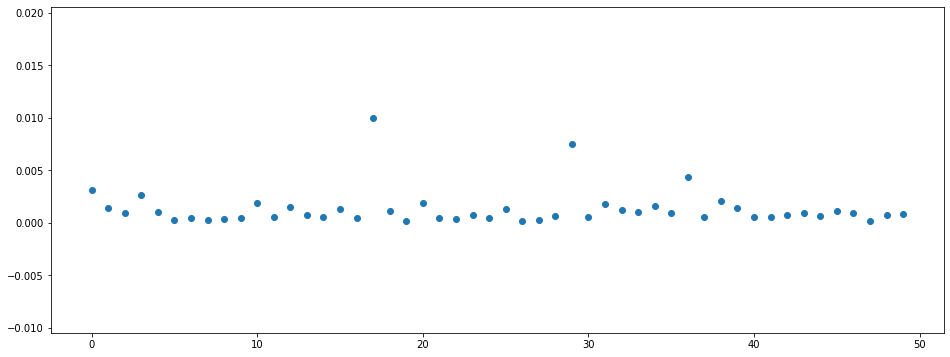

In [738]:
predictions = autoencoder.predict(arr_clustering[[75]])
mse = np.mean(np.power(arr_clustering[[75]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(arr_clustering.shape[1]), mse)

In [749]:
mse

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [739]:
pred = autoencoder.predict(arr_clustering).shape
from sklearn.cluster import KMeans
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(pred)

ValueError: Expected 2D array, got 1D array instead:
array=[181.  50.   5.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

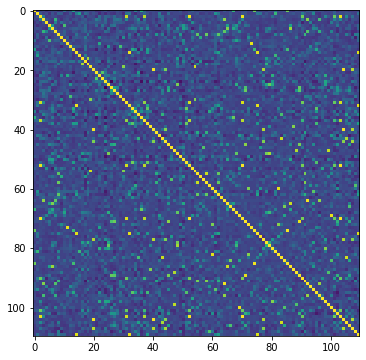

In [740]:
df = np.mean(np.power(arr_clustering[71:] - autoencoder.predict(arr_clustering[71:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
np.set_printoptions(False)

In [742]:
df.shape

(110, 50)

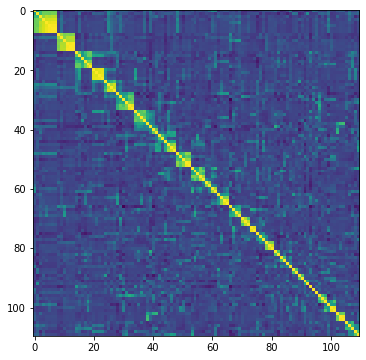

In [699]:
d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
np.set_printoptions(False)

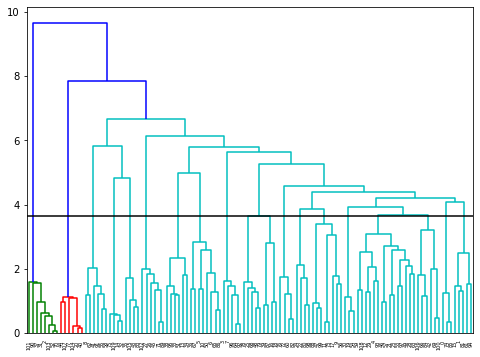

In [700]:
plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L)
plt.axhline(d.max(), c='black')

In [701]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

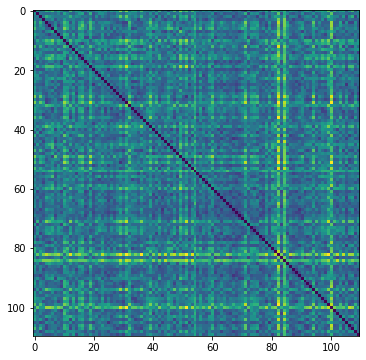

In [702]:

### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = np.mean(np.power(arr_clustering[71:] - autoencoder.predict(arr_clustering[71:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)

np.set_printoptions(False)

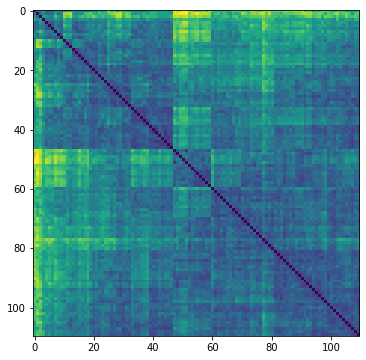

In [703]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
np.set_printoptions(False)

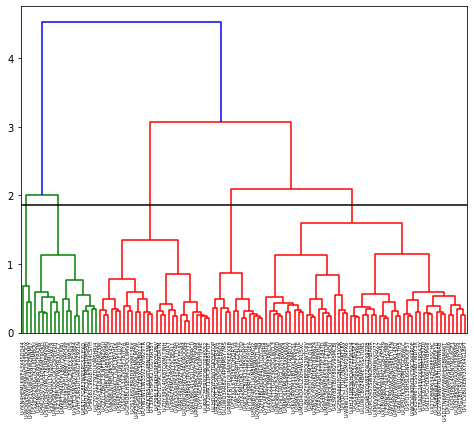

In [706]:
### PLOT DENDROGRAM ###
plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L,labels=df_clustering.participant_id.unique())
plt.axhline(d.max(), c='black')

In [708]:
c = pd.DataFrame.from_dict(dendrogram, orient='index').transpose()
c_sub = c[['ivl','color_list']]

c_sub.groupby('color_list').count()

,ivl
color_list,
b,1
g,18
r,90


In [714]:
df[0].shape

(50,)

In [710]:
red = c_sub[c_sub["color_list"] == 'r']
red = red['ivl']
red

18     U-JC7D751Z79ZDUQMSHRJ4
19     U-X8Q3A3Z18ZBAXJ6DMZ5W
20     U-QZLLZBKC13LNFT9NZASU
21     U-V76SUGHBLWUJ4B3RPXPN
22     U-NKN8LN7MFUPK5531543Y
                ...          
103    U-L27PSMNP7UA7UX6WNNRB
104    U-SDZ7N6MWYWWHHDBRM46T
105    U-FAAUXAWPNVSPTWVPGUJ6
106    U-SQ43PJK145DN7N2L6GF1
107    U-UU3LBKS5HVAXUU3X8WPR
Name: ivl, Length: 90, dtype: object

In [431]:
df_FIT_red = df_FIT[df_FIT.participant_id.isin(red)]

In [432]:
df_FIT_red.dtypes

date              datetime64[ns]
participant_id            object
rmssd                    float64
hr_average               float64
awake                      int64
deep                       int64
total                      int64
dtype: object

In [433]:
df_FIT_red['deep'] = df_FIT_red['deep'].astype(float)
df_FIT_red['awake'] = df_FIT_red['awake'].astype(float)
df_FIT_red['total'] = df_FIT_red['total'].astype(float)

df_FIT_red.dtypes

date              datetime64[ns]
participant_id            object
rmssd                    float64
hr_average               float64
awake                    float64
deep                     float64
total                    float64
dtype: object

In [629]:
# Other 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings(action='ignore')

def construct_dataset(df, columns, duration):
    y = []
    x = []
    
    participants = df.participant_id.unique()
    
    
    #keep data we want, drop the rest
    df_subset = df[columns]
    
    for participant in participants:
        #import pdb; pdb.set_trace()
        df = df_subset[df_subset["participant_id"] == participant]
        df_y = df
        #Create Empty NaN rows for missing dates
        df = df.set_index('date')
        df = df.resample('D').mean()
        
        #Forward Fill missing values. If time stamp is missing, fill with column mean
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        
        #if any still missing fill with population mean
        df = df.fillna(df_subset.mean())
        
        df['rmssd']= df['rmssd'].apply(np.ceil)
        
        #Loop through windows of window_length. First check to see if there are enough days for at least one window
        #Only get participants who have at least duration days observed (including missing days)
        
        if len(df) >= duration+1:
            window = df.iloc[0:duration,:]
            window_y = df.iloc[0:duration,:]
            #import pdb; pdb.set_trace()
            
            scale = StandardScaler().fit(window_y[['rmssd']])
            window_y['rmssd'] = scale.transform(window_y[['rmssd']])
            stress = window_y['rmssd']
            
            y.append(np.array(stress))
            
            
            #drop label column to prevent leakage
            window = window.drop(["rmssd"], axis=1)
            
            # standardize each col separately
            num_cols = ['hr_average','awake','deep','total']
            new = window.copy()
            for i in num_cols:
                scale = StandardScaler().fit(window[[i]])
                new[i] = scale.transform(new[[i]])
            
            data = new.values
            standardized_data = data
            standardized_df = pd.DataFrame(standardized_data)
            arrays = [np.array(new[column]) for column in new.columns]
            x.append(np.stack(arrays, axis=0))
            
    return np.array(x), np.array(y)

In [630]:
train = df_FIT_red.participant_id.unique()[0:80]
test  = df_FIT_red.participant_id.unique()[81:]

In [631]:
train_df = df_FIT_red[df_FIT_red.participant_id.isin(train)]
test_df = df_FIT_red[df_FIT_red.participant_id.isin(test)]

In [632]:
x_train, y_train = construct_dataset(train_df, columns, 80)
x_test, y_test = construct_dataset(test_df, columns, 80)

In [633]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(79, 4, 80)
(79, 80)
(27, 4, 80)
(27, 80)


In [634]:
def save_data(path,array):
    with open(path,'wb') as f:
        pickle.dump(array, f)

In [635]:
save_data('data/results/clustering/x_train.pkl', x_train)
save_data('data/results/clustering/x_test.pkl', x_test)
save_data('data/results/clustering/y_train.pkl', y_train)
save_data('data/results/clustering/y_test.pkl', y_test)

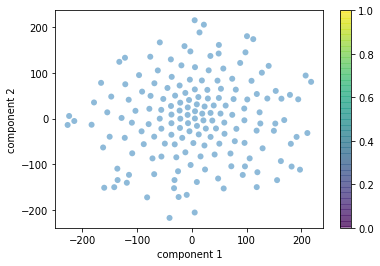

In [688]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
#NO SCALING
pipeline = Pipeline([('pca', TSNE(n_components=2,
                                  init="pca",
                                  learning_rate=1000,
                                  perplexity=50
                                 ))])
projected=pipeline.fit_transform(df)
plt.scatter(projected[:,0], projected[:, 1],
             edgecolor='none', alpha=0.5,
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [690]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.values)
labels_encoded=le.transform(df.values)
plt.scatter(projected[:,0], projected[:, 1],
            c=labels_encoded,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdYlGn', 353)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

ValueError: y should be a 1d array, got an array of shape (171, 50) instead.

In [752]:
def ffill_df(df):
    x = []
    
    participants = df.participant_id.unique()
    a = pd.DataFrame()
    #keep data we want, drop the rest
    df_subset = df

    for participant in participants:
        df = df_subset[df_subset["participant_id"] == participant]
        
        #Create Empty NaN rows for missing dates
        df = df.set_index('date')
        df = df.resample('D').mean()
        
        #Forward Fill missing values. If time stamp is missing, fill with column mean
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        
        #if any still missing fill with population mean
        df = df.fillna(df_subset.mean())
        df['participant_id'] = participant
        a = a.append(df, ignore_index=True)
    return a

In [754]:
new_df = ffill_df(df_clustering)

In [755]:
data = np.asarray([np.asarray(new_df['awake']),np.asarray(new_df['total'])]).T.astype(float)

Text(0.5, 1.0, 'Elbow curve')

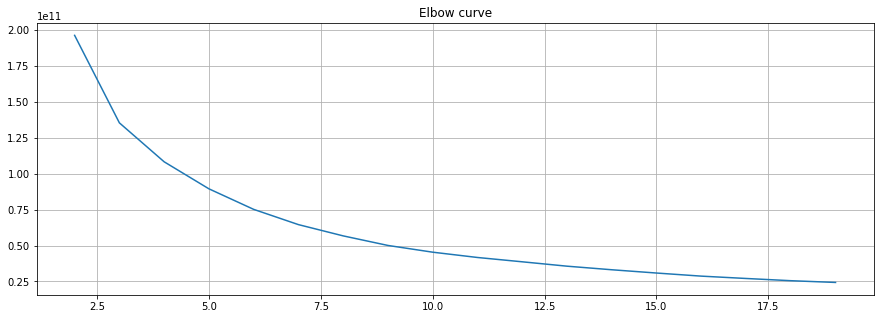

In [756]:
from sklearn.cluster import KMeans
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [757]:
from scipy.cluster.vq import kmeans,vq
centroids,_ = kmeans(X, 5)

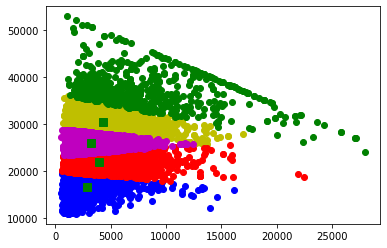

In [758]:
from matplotlib import pyplot as plt
from pylab import plot,show
idx,_ = vq(data,centroids)
# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

In [129]:
idx

array([ 9, 11,  0, ...,  0,  9,  9], dtype=int32)

In [128]:
data.shape

(38002, 2)